In [3]:
import numpy as np
import pandas as pd
from ast import literal_eval

# load data
datafile_path = "./data/embeddings.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape

(20, 1536)

In [2]:
df["category_encoded"].unique()

array([35,  5, 22, 40,  7, 32, 28], dtype=int64)

In [8]:
from sklearn.cluster import KMeans

n_clusters = 7

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
print(labels)
df["Cluster"] = labels

cluster_centers = df.groupby("Cluster").embedding.mean()
cluster_centers.values

[0 2 4 4 2 1 2 6 5 3 3 3 6 2 2 1 5 1 3 6]


c:\Users\EmilyXia\anaconda3\envs\tensor_py3.8\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([array([-0.01542859, -0.02962708,  0.00955945, ..., -0.02613308,
               0.00638605, -0.00031284])                              ,
       array([ 0.00115484, -0.0030482 ,  0.01202154, ...,  0.00056711,
              -0.01084431, -0.00256133])                              ,
       array([-0.01627253, -0.02329435,  0.01514663, ..., -0.00518252,
              -0.01749945, -0.0116682 ])                              ,
       array([-0.00942666, -0.01666223,  0.01427484, ..., -0.00207435,
               0.00768258, -0.0043811 ])                              ,
       array([ 0.00804171,  0.01241068,  0.01344363, ...,  0.00558627,
              -0.00685094, -0.0412705 ])                              ,
       array([ 0.00278943, -0.00969637,  0.00999494, ...,  0.00011264,
              -0.01335347, -0.01437592])                              ,
       array([-0.01172645, -0.01438096, -0.00681503, ..., -0.01572391,
              -0.01991296, -0.00373434])                              ]

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

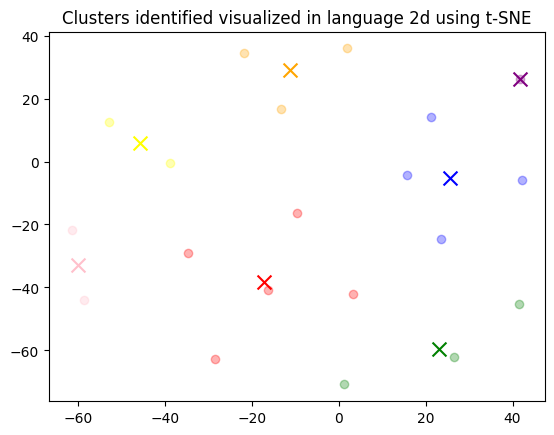

In [10]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "yellow", "pink", "orange"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [45]:
# choose several near classes if the distances are smaller than the threshold
def choose_near_classes(embed, num_near_classes, threshold, class_centers):
    chosen_classes = []
    for i, center in enumerate(class_centers):
        dis = np.linalg.norm(embed - center)
        if dis < threshold:
            chosen_classes.append([i, dis])
    chosen_classes = sorted(chosen_classes, key=lambda x: x[1])
    return chosen_classes[:num_near_classes]

# output the class feature value: 1.0 -> dis btw doc and home class center, value -> dis btw doc and other class center/ dis btw doc and home class center
def get_class_feature_value(near_classes, num_classes):
    doc_home_dis = near_classes[0][1]
    doc_topic_feature = np.zeros(num_classes)

    for i in near_classes:
        doc_topic_feature[i[0]] = doc_home_dis / (i[1] + 0.000001)
    return doc_topic_feature

In [57]:
near_classes = choose_near_classes(matrix[3], 4, 0.6, cluster_centers.values)
doc_topic_feature = get_class_feature_value(near_classes, n_clusters)

all_doc_topic_feature = list(map(lambda x: get_class_feature_value(choose_near_classes(x, 4, 0.6, cluster_centers.values), n_clusters), matrix))
print(len(all_doc_topic_feature[0]))
# save to csv file && add header
df = pd.DataFrame(all_doc_topic_feature)
df.to_csv('./data/doc_topic_feature.csv')

# test outcome
df = pd.read_csv('./data/doc_topic_feature.csv')
features = np.array(df.values[:, 1:])
print(features.shape)


7
(20, 7)
